In [34]:
#Importamos las librerías que vamos a necesitar
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')

In [35]:
# Librería para manejar archivos .env, para cargar tokens y claves
import os
import dotenv
dotenv.load_dotenv()

True

In [36]:
# Librería para trabajar con bases de datos SQL
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors

In [37]:
df_supermercados = pd.read_csv(f"../datos/df_supermercados.csv")

In [38]:
df_supermercados.sample(25)

,Unnamed: 0,supermercado,categoria_producto,nombre_producto,subcategoria,Día,Precio (€),cantidad_variacion,porcentaje_variacion
69975,781,dia,aceite de oliva,borges aceite de oliva virgen extra picual bot...,virgen extra,2024-09-09,9.51,0.0,0.0
182809,12314,mercadona,aceite de oliva,valdezarza aceite de oliva virgen extra botell...,virgen extra,2024-09-17,6.18,0.0,0.0
95186,12186,dia,leche,pascual leche de vaca semidesnatada y sin lact...,semidesnatada,2024-08-16,1.15,0.0,0.0
73653,4459,dia,aceite de oliva,coosur aceite de oliva virgen extra picual int...,virgen extra,2024-10-03,13.24,0.0,0.0
58509,9276,carrefour,leche,lr leche entera 6 x 1 l,entera,2024-08-22,5.28,0.0,0.0
179138,8643,mercadona,aceite de oliva,mar de olivos aceite de oliva virgen garrafa 5 l,virgen,2024-09-09,50.46,0.0,0.0
123852,7085,eroski,leche,central lechera asturiana leche entera de vaca...,entera,2024-07-25,0.75,0.0,0.0
167090,16556,hipercor,leche,puleva leche fresca de vaca semidesnatada 1 l,semidesnatada,2024-08-24,1.61,0.0,0.0
175221,4726,mercadona,aceite de oliva,fruto del sur aceite de oliva virgen extra bot...,virgen extra,2024-08-02,8.56,0.0,0.0
38055,2628,carrefour,aceite de oliva,carbonell gran seleccion aceite de oliva virge...,virgen extra,2024-10-22,4.02,0.0,0.0


## Preparación de las tablas para la base de datos

### Tabla productos

In [5]:
# Eliminamos la columna "Unnamed 0"
df_supermercados.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
# Añadimos la columna id_producto que mapea los valores 1,2 y 3, a los valores de la columna categoria_producto,
# aceite de girasol, aceite de oliva y leche, respectivamente
df_supermercados['id_producto'] = df_supermercados['categoria_producto'].map({
    'aceite de girasol': 1,
    'aceite de oliva': 2,
    'leche': 3
})

In [7]:
#Analogamente añadimos una columna id_super que asignar valores de 1 a 6 segun el valor de la columna supermercado

df_supermercados['id_super'] = df_supermercados['supermercado'].map({
    'alcampo': 1,
    'carrefour': 2,
    'dia': 3,
    'eroski': 4,
    'hipercor': 5,
    'mercadona': 6
})

In [8]:
df_supermercados.rename(columns={'categoria_producto': 'nombre'}, inplace=True)
df_supermercados.head()

,supermercado,nombre,nombre_producto,subcategoria,Día,Precio (€),cantidad_variacion,porcentaje_variacion,id_producto,id_super
0,alcampo,aceite de girasol,campomar nature aceite de girasol ecologico ca...,NaN,2024-06-30,5.88,0.0,0.0,1,1
1,alcampo,aceite de girasol,campomar nature aceite de girasol ecologico ca...,NaN,2024-07-01,5.88,0.0,0.0,1,1
2,alcampo,aceite de girasol,campomar nature aceite de girasol ecologico ca...,NaN,2024-07-12,5.88,0.0,0.0,1,1
3,alcampo,aceite de girasol,campomar nature aceite de girasol ecologico ca...,NaN,2024-07-13,5.88,0.0,0.0,1,1
4,alcampo,aceite de girasol,campomar nature aceite de girasol ecologico ca...,NaN,2024-07-14,5.88,0.0,0.0,1,1


In [9]:
# Creamos un dataFrame que se con las columnas id_producto y nombre de df_supermercados, 
# del que quitamos esas dos mismas columnas
df_productos = df_supermercados[['nombre', 'id_producto']].drop_duplicates().reset_index(drop=True)
df_supermercados.drop(columns=['nombre'], inplace=True)
df_productos.head()

,nombre,id_producto
0,aceite de girasol,1
1,aceite de oliva,2
2,leche,3


In [10]:
df_superm = df_supermercados[['supermercado', 'id_super']].drop_duplicates().reset_index(drop=True)
df_supermercados.drop(columns=['supermercado'], inplace=True)

In [11]:
df_superm

,supermercado,id_super
0,alcampo,1
1,carrefour,2
2,dia,3
3,eroski,4
4,hipercor,5
5,mercadona,6


In [12]:
df_historico = df_supermercados.reindex(columns=['id_super', 'id_producto', 'nombre_producto', 'subcategoria', 'Día', 'Precio (€)', 'cantidad_variacion', 'porcentaje_variacion'])
df_historico.sample(5)

,id_super,id_producto,nombre_producto,subcategoria,Día,Precio (€),cantidad_variacion,porcentaje_variacion
54864,2,3,central lechera asturiana leche desnatada 0 ma...,desnatada,2024-08-09,6.54,0.0,0.0
59952,2,3,lauki leche desnatada 0 materia grasa de vaca ...,desnatada,2024-09-01,5.70,0.0,0.0
180033,6,2,olivar centenario aceite de oliva virgen garra...,virgen,2024-09-06,50.46,0.0,0.0
78720,3,2,olivar centenario aceite de oliva virgen garra...,virgen,2024-08-25,50.46,0.0,0.0
4548,1,2,carbonell gran seleccion aceite de oliva virge...,virgen extra,2024-09-02,9.28,0.0,0.0


In [13]:
df_historico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202602 entries, 0 to 202601
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id_super              202602 non-null  int64  
 1   id_producto           202602 non-null  int64  
 2   nombre_producto       202602 non-null  object 
 3   subcategoria          162234 non-null  object 
 4   Día                   202602 non-null  object 
 5   Precio (€)            202602 non-null  float64
 6   cantidad_variacion    202602 non-null  float64
 7   porcentaje_variacion  202602 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 12.4+ MB


Los DataFrames df_historico, df_productos y df_superm son los dataFrames en los que vamos a basar las tres tablas de nuestra base de datos.

A continuacion guardamso estos DataFrames como csv por si los pudieramos necesitar en el futuro, y preparamos los datos de estos DataFrames como lista de tuplas que es el formato en el que hacemos la insercion de datos en tablas de bases de datos de SQL.

In [14]:
df_productos.to_csv("../datos/tabla_productos.csv")

In [15]:
lista_tuplas_productos = []
for fila in df_productos.values:
    lista_tuplas_productos.append(tuple(fila))

In [16]:
df_superm.to_csv("../datos/tabla_superm.csv")

In [17]:
lista_tuplas_supermercados = []
for fila in df_superm.values:
    lista_tuplas_supermercados.append(tuple(fila))

In [18]:
df_historico.to_csv("../datos/tabla_historico.csv")

In [19]:
lista_tuplas_historico = []
for fila in df_historico.values:
    lista_tuplas_historico.append(tuple(fila))

In [20]:
#Guardamos de forma segura la contraeña para conectarnos a la base de datos.
key = os.getenv("token")

## Conexion a la base de datos

In [21]:
def conexion_a_dbeaver(database):
    """
    Establece una conexión a una base de datos DBeaver.

    Args:
        database (str): El nombre de la base de datos.

    Returns:
        conexion: Un objeto de conexión a la base de datos.
    """
    try:
        conexion = psycopg2.connect(
            database=database,
            user="postgres",
            password=key,
            host="localhost",
            port="5432"
        )
    except OperationalError as e:
        if e.pgcode == errorcodes.INVALID_PASSWORD:
            print("La contraseña intorducida es errónea")
        elif e.pgcode == errorcodes.CONNECTION_EXCEPTION:
            print("Se ha producido un error de conexión")
        else:
            print(f"Ocurrió el error {e}")
    return conexion

In [22]:
conexion=conexion_a_dbeaver("supermercados")
cursor=conexion.cursor()

## Creacion de las tablas de la base de datos

In [23]:
def creacion_tablas(conexion, cursor):
    try:
        # Creación tabla supermercado
        query_creacion_supermercado = '''
            create table if not exists supermercado(
                id_super int primary key,
                nombre VARCHAR(50) not null
            ); '''

        cursor.execute(query_creacion_supermercado)
        conexion.commit()

        # Creación tabla tipo_producto
        query_creacion_tipo_producto = '''
            create table if not exists tipo_producto(
                id_producto int primary key,
                nombre VARCHAR(100) not null
                ); '''

        cursor.execute(query_creacion_tipo_producto)
        conexion.commit()

        # Creación tabla comparativa
        query_creacion_historico = """
            create table if not exists historico (
                id_historico serial primary key,
                id_super integer not null,
                id_producto integer not null,
                nombre varchar(300) not null,
                subcategoria varchar(200),
                fecha date not null,
                precio float,
                variacion float,
                porcentaje float,
                foreign key (id_super) references supermercado(id_super)
                    on update cascade
                    on delete restrict,
                foreign key (id_producto) references tipo_producto(id_producto)
                    on update cascade 
                    on delete restrict
                );"""

        cursor.execute(query_creacion_historico)
        conexion.commit()

    except Exception as e:
        print(f"Error creando tablas: {e}")


In [24]:
creacion_tablas(conexion, cursor)

Estas son las tablas, con su diagrama que se han creado en dbeaver

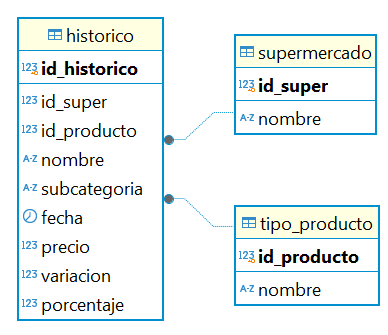

## Insercion de datos en las tablas

In [25]:
query_insercion_supermercado = '''
    insert into supermercado (nombre, id_super)
    values
    (%s, %s)''' 



In [26]:
query_insercion_tipo_producto = '''
    insert into tipo_producto (nombre, id_producto)
    values
    (%s, %s)''' 



In [27]:
query_insercion_historico = '''
    insert into historico (id_super, id_producto, nombre, subcategoria, fecha, precio, variacion, porcentaje) 
    values 
    (%s, %s, %s, %s, %s, %s, %s, %s)'''

In [28]:
def insercion_datos(conexion, cursor, lista_tuplas, query_insercion):
    cursor.executemany(query_insercion, lista_tuplas)
    conexion.commit() 

In [29]:
insercion_datos(conexion, cursor, lista_tuplas_supermercados, query_insercion_supermercado)
insercion_datos(conexion, cursor, lista_tuplas_productos, query_insercion_tipo_producto)
insercion_datos(conexion, cursor, lista_tuplas_historico, query_insercion_historico)



La inserción de datos en dbeaver ha sido exitosa

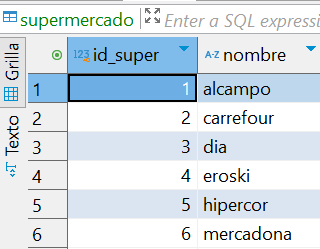  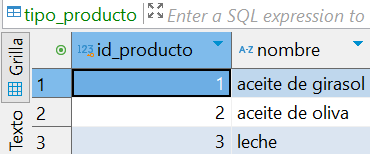

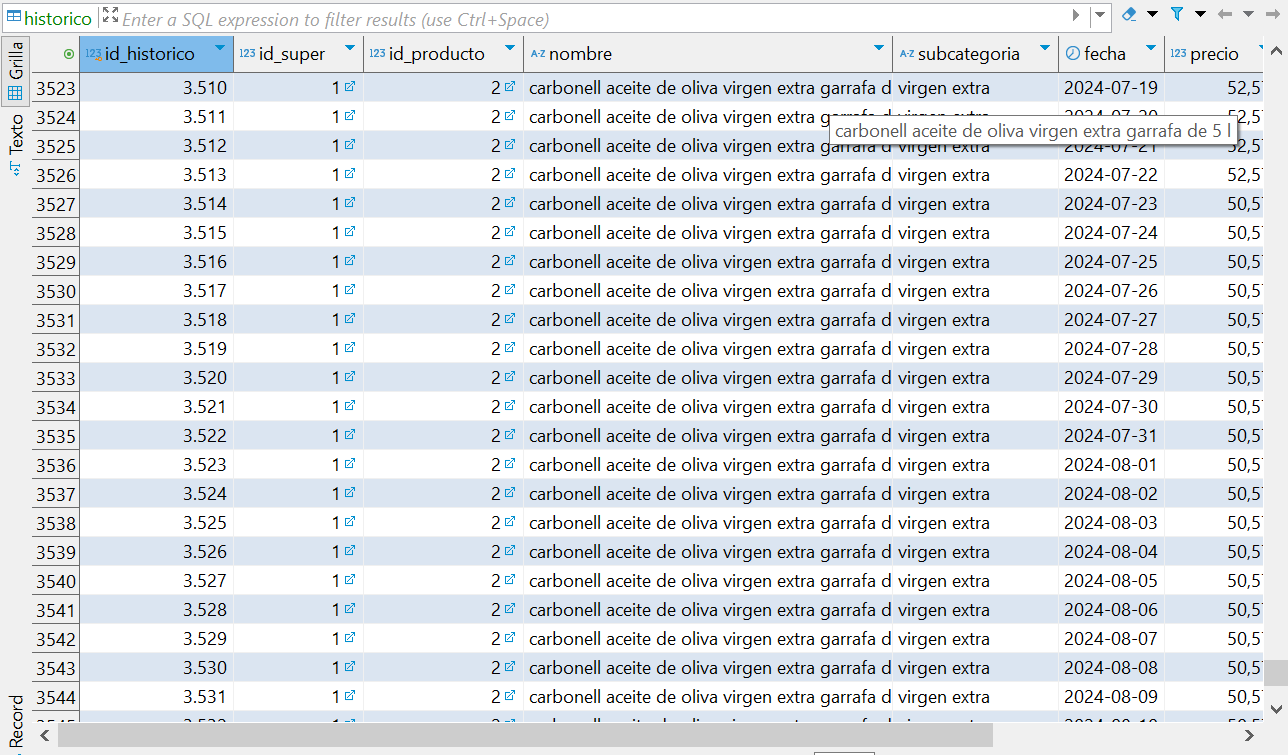

Cerramos la conexion a la base de datos

In [30]:
cursor.close()
conexion.close()

In [32]:
# Reajustar el código para evitar problemas de cruce en el merge
# Determinar los supermercados con el precio más bajo y el más alto para cada producto

# Encontrar el precio mínimo y máximo para cada producto
precio_min = df_supermercados.groupby('nombre_producto')['Precio (€)'].min().reset_index(name='Precio Minimo')
precio_max = df_supermercados.groupby('nombre_producto')['Precio (€)'].max().reset_index(name='Precio Maximo')

# Identificar supermercados con precios mínimos y máximos al unir por 'nombre_producto'
df_min = df_supermercados.merge(precio_min, left_on=['nombre_producto', 'Precio (€)'], right_on=['nombre_producto', 'Precio Minimo'])
df_max = df_supermercados.merge(precio_max, left_on=['nombre_producto', 'Precio (€)'], right_on=['nombre_producto', 'Precio Maximo'])

# Concatenar ambos DataFrames para ver los supermercados con precios más bajos y más altos
resultado_precios = pd.concat([df_min, df_max]).drop_duplicates(subset=['nombre_producto', 'supermercado', 'Precio (€)'])



KeyError: Index(['supermercado'], dtype='object')